<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:42] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


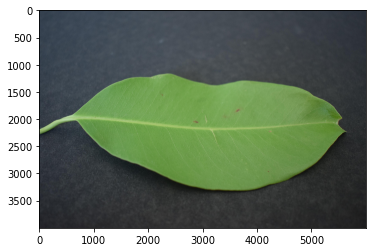

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

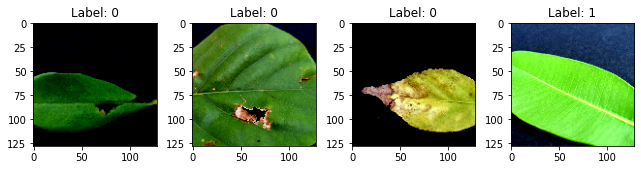

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:48] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:50] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2599290132225134 samples/sec                   batch loss = 2.7595903873443604 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2637696731272485 samples/sec                   batch loss = 0.8803873062133789 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2716969845168318 samples/sec                   batch loss = 0.30668631196022034 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.26931984413071 samples/sec                   batch loss = 0.676628828048706 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2445459368549987 samples/sec                   batch loss = 1.2393800020217896 | accuracy = 0.5


Epoch[1] Batch[30] Speed: 1.2285183045918768 samples/sec                   batch loss = 0.5242935419082642 | accuracy = 0.49166666666666664


Epoch[1] Batch[35] Speed: 1.2718006158871225 samples/sec                   batch loss = 0.39277780055999756 | accuracy = 0.5357142857142857


Epoch[1] Batch[40] Speed: 1.273843910611734 samples/sec                   batch loss = 0.9984095692634583 | accuracy = 0.53125


Epoch[1] Batch[45] Speed: 1.2665277784383235 samples/sec                   batch loss = 0.8502252101898193 | accuracy = 0.55


Epoch[1] Batch[50] Speed: 1.2709041612579888 samples/sec                   batch loss = 0.2841486930847168 | accuracy = 0.56


Epoch[1] Batch[55] Speed: 1.2674251528490372 samples/sec                   batch loss = 0.6102966070175171 | accuracy = 0.5636363636363636


Epoch[1] Batch[60] Speed: 1.2679824532896151 samples/sec                   batch loss = 0.8524113297462463 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.271423382476166 samples/sec                   batch loss = 0.4931466281414032 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.2784729177855796 samples/sec                   batch loss = 1.3110524415969849 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.2701874261316064 samples/sec                   batch loss = 0.654240608215332 | accuracy = 0.5766666666666667


Epoch[1] Batch[80] Speed: 1.2823208018540635 samples/sec                   batch loss = 0.7895956635475159 | accuracy = 0.578125


Epoch[1] Batch[85] Speed: 1.2732366104884902 samples/sec                   batch loss = 0.41263291239738464 | accuracy = 0.5823529411764706


Epoch[1] Batch[90] Speed: 1.2730754571103085 samples/sec                   batch loss = 0.5752779245376587 | accuracy = 0.5916666666666667


Epoch[1] Batch[95] Speed: 1.2688875530669064 samples/sec                   batch loss = 0.8799229264259338 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.2672671901444335 samples/sec                   batch loss = 0.30898454785346985 | accuracy = 0.615


Epoch[1] Batch[105] Speed: 1.2636741993544098 samples/sec                   batch loss = 0.3220638930797577 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.269864490998058 samples/sec                   batch loss = 0.2788834869861603 | accuracy = 0.6386363636363637


Epoch[1] Batch[115] Speed: 1.2688228739417222 samples/sec                   batch loss = 0.31310954689979553 | accuracy = 0.6434782608695652


Epoch[1] Batch[120] Speed: 1.2628737584353906 samples/sec                   batch loss = 0.4388517737388611 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.2716590066437397 samples/sec                   batch loss = 0.7727673053741455 | accuracy = 0.644


Epoch[1] Batch[130] Speed: 1.2696031097875855 samples/sec                   batch loss = 0.49646949768066406 | accuracy = 0.6403846153846153


Epoch[1] Batch[135] Speed: 1.2677930234573829 samples/sec                   batch loss = 0.6386432647705078 | accuracy = 0.6425925925925926


Epoch[1] Batch[140] Speed: 1.265612578927207 samples/sec                   batch loss = 0.6255694627761841 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.2692700047601742 samples/sec                   batch loss = 1.1427358388900757 | accuracy = 0.6379310344827587


Epoch[1] Batch[150] Speed: 1.2680420630522529 samples/sec                   batch loss = 0.38651108741760254 | accuracy = 0.6383333333333333


Epoch[1] Batch[155] Speed: 1.263882489746389 samples/sec                   batch loss = 0.3790103793144226 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2607779268634973 samples/sec                   batch loss = 0.7704299092292786 | accuracy = 0.6359375


Epoch[1] Batch[165] Speed: 1.266487718541241 samples/sec                   batch loss = 0.3038663864135742 | accuracy = 0.6409090909090909


Epoch[1] Batch[170] Speed: 1.267966353864848 samples/sec                   batch loss = 0.30599772930145264 | accuracy = 0.6426470588235295


Epoch[1] Batch[175] Speed: 1.2640779910332012 samples/sec                   batch loss = 0.41520291566848755 | accuracy = 0.6485714285714286


Epoch[1] Batch[180] Speed: 1.2761960066388418 samples/sec                   batch loss = 0.45458292961120605 | accuracy = 0.6430555555555556


Epoch[1] Batch[185] Speed: 1.2707554364674771 samples/sec                   batch loss = 0.48022791743278503 | accuracy = 0.6432432432432432


Epoch[1] Batch[190] Speed: 1.2667352891055599 samples/sec                   batch loss = 0.24832691252231598 | accuracy = 0.6447368421052632


Epoch[1] Batch[195] Speed: 1.269341932193939 samples/sec                   batch loss = 0.7471522688865662 | accuracy = 0.6423076923076924


Epoch[1] Batch[200] Speed: 1.2661880667707306 samples/sec                   batch loss = 0.7601305246353149 | accuracy = 0.645


Epoch[1] Batch[205] Speed: 1.2678492620164898 samples/sec                   batch loss = 0.4745844602584839 | accuracy = 0.65


Epoch[1] Batch[210] Speed: 1.2614872093821499 samples/sec                   batch loss = 0.516726016998291 | accuracy = 0.6511904761904762


Epoch[1] Batch[215] Speed: 1.2681750072584452 samples/sec                   batch loss = 0.2855915427207947 | accuracy = 0.6534883720930232


Epoch[1] Batch[220] Speed: 1.2669605677287692 samples/sec                   batch loss = 0.7312898635864258 | accuracy = 0.6534090909090909


Epoch[1] Batch[225] Speed: 1.2668765691337054 samples/sec                   batch loss = 0.42492422461509705 | accuracy = 0.6533333333333333


Epoch[1] Batch[230] Speed: 1.2681288043090881 samples/sec                   batch loss = 0.3986371159553528 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.2692239140282653 samples/sec                   batch loss = 0.2660253942012787 | accuracy = 0.6585106382978724


Epoch[1] Batch[240] Speed: 1.2703087014079295 samples/sec                   batch loss = 0.2697770297527313 | accuracy = 0.6604166666666667


Epoch[1] Batch[245] Speed: 1.2713582518969533 samples/sec                   batch loss = 0.4257580041885376 | accuracy = 0.6591836734693878


Epoch[1] Batch[250] Speed: 1.2702925428571514 samples/sec                   batch loss = 0.6156220436096191 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2661560549509332 samples/sec                   batch loss = 0.6605913639068604 | accuracy = 0.6549019607843137


Epoch[1] Batch[260] Speed: 1.2731948690080188 samples/sec                   batch loss = 0.7117522358894348 | accuracy = 0.6557692307692308


Epoch[1] Batch[265] Speed: 1.2687302810340915 samples/sec                   batch loss = 0.7989030480384827 | accuracy = 0.6528301886792452


Epoch[1] Batch[270] Speed: 1.2696790145655894 samples/sec                   batch loss = 1.3026463985443115 | accuracy = 0.6527777777777778


Epoch[1] Batch[275] Speed: 1.2764043671837215 samples/sec                   batch loss = 0.4925176501274109 | accuracy = 0.6527272727272727


Epoch[1] Batch[280] Speed: 1.2714154816656549 samples/sec                   batch loss = 0.5018519759178162 | accuracy = 0.6517857142857143


Epoch[1] Batch[285] Speed: 1.2700128150266086 samples/sec                   batch loss = 0.614146888256073 | accuracy = 0.6508771929824562


Epoch[1] Batch[290] Speed: 1.2712741508290493 samples/sec                   batch loss = 0.3057563304901123 | accuracy = 0.6551724137931034


Epoch[1] Batch[295] Speed: 1.2687800780270417 samples/sec                   batch loss = 0.5188702344894409 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.2750664523976634 samples/sec                   batch loss = 0.6369573473930359 | accuracy = 0.6575


Epoch[1] Batch[305] Speed: 1.269808361841906 samples/sec                   batch loss = 0.6962726712226868 | accuracy = 0.659016393442623


Epoch[1] Batch[310] Speed: 1.2671157743875674 samples/sec                   batch loss = 0.7576754689216614 | accuracy = 0.6612903225806451


Epoch[1] Batch[315] Speed: 1.2687274027146953 samples/sec                   batch loss = 0.2373282015323639 | accuracy = 0.6634920634920635


Epoch[1] Batch[320] Speed: 1.2726652218988448 samples/sec                   batch loss = 0.7073760032653809 | accuracy = 0.6625


Epoch[1] Batch[325] Speed: 1.2675642883753604 samples/sec                   batch loss = 0.4439465403556824 | accuracy = 0.6646153846153846


Epoch[1] Batch[330] Speed: 1.27144014793592 samples/sec                   batch loss = 0.5859397053718567 | accuracy = 0.6659090909090909


Epoch[1] Batch[335] Speed: 1.2736681961319005 samples/sec                   batch loss = 0.6800205111503601 | accuracy = 0.6671641791044776


Epoch[1] Batch[340] Speed: 1.2620206919984767 samples/sec                   batch loss = 0.573297381401062 | accuracy = 0.6676470588235294


Epoch[1] Batch[345] Speed: 1.2648057718487729 samples/sec                   batch loss = 0.12750005722045898 | accuracy = 0.6702898550724637


Epoch[1] Batch[350] Speed: 1.2664139155335363 samples/sec                   batch loss = 0.23244552314281464 | accuracy = 0.6714285714285714


Epoch[1] Batch[355] Speed: 1.265889416396803 samples/sec                   batch loss = 0.3233124613761902 | accuracy = 0.6711267605633803


Epoch[1] Batch[360] Speed: 1.2682676150064736 samples/sec                   batch loss = 0.4223049581050873 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.2651691656521513 samples/sec                   batch loss = 0.6995567679405212 | accuracy = 0.6746575342465754


Epoch[1] Batch[370] Speed: 1.267348559953419 samples/sec                   batch loss = 0.686259388923645 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2673667499278962 samples/sec                   batch loss = 0.5356910824775696 | accuracy = 0.6753333333333333


Epoch[1] Batch[380] Speed: 1.2650462942017786 samples/sec                   batch loss = 0.37717247009277344 | accuracy = 0.6743421052631579


Epoch[1] Batch[385] Speed: 1.2689851600158566 samples/sec                   batch loss = 0.6489688158035278 | accuracy = 0.6727272727272727


Epoch[1] Batch[390] Speed: 1.2649101904216837 samples/sec                   batch loss = 0.4651016592979431 | accuracy = 0.6737179487179488


Epoch[1] Batch[395] Speed: 1.2677932150624016 samples/sec                   batch loss = 0.6497889757156372 | accuracy = 0.6759493670886076


Epoch[1] Batch[400] Speed: 1.2660246801078217 samples/sec                   batch loss = 0.6666138172149658 | accuracy = 0.67375


Epoch[1] Batch[405] Speed: 1.2649277382483002 samples/sec                   batch loss = 0.5520634651184082 | accuracy = 0.674074074074074


Epoch[1] Batch[410] Speed: 1.26436035094761 samples/sec                   batch loss = 0.34120115637779236 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.2615224004002652 samples/sec                   batch loss = 0.7241636514663696 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.2620849642984329 samples/sec                   batch loss = 0.860034167766571 | accuracy = 0.6791666666666667


Epoch[1] Batch[425] Speed: 1.2640779910332012 samples/sec                   batch loss = 1.5536584854125977 | accuracy = 0.678235294117647


Epoch[1] Batch[430] Speed: 1.2636503093707838 samples/sec                   batch loss = 1.1725021600723267 | accuracy = 0.6779069767441861


Epoch[1] Batch[435] Speed: 1.2664547355640776 samples/sec                   batch loss = 0.3979046642780304 | accuracy = 0.6781609195402298


Epoch[1] Batch[440] Speed: 1.2665945186915977 samples/sec                   batch loss = 0.9433223009109497 | accuracy = 0.6755681818181818


Epoch[1] Batch[445] Speed: 1.2657173217413216 samples/sec                   batch loss = 1.033703088760376 | accuracy = 0.6747191011235955


Epoch[1] Batch[450] Speed: 1.2654876167932276 samples/sec                   batch loss = 0.940337598323822 | accuracy = 0.6733333333333333


Epoch[1] Batch[455] Speed: 1.2674947646726098 samples/sec                   batch loss = 0.6440428495407104 | accuracy = 0.6752747252747253


Epoch[1] Batch[460] Speed: 1.2746798222081208 samples/sec                   batch loss = 0.3935856223106384 | accuracy = 0.6755434782608696


Epoch[1] Batch[465] Speed: 1.2709636609221395 samples/sec                   batch loss = 0.7934038639068604 | accuracy = 0.6768817204301075


Epoch[1] Batch[470] Speed: 1.267026779482481 samples/sec                   batch loss = 0.4496002793312073 | accuracy = 0.6781914893617021


Epoch[1] Batch[475] Speed: 1.2743031052354825 samples/sec                   batch loss = 0.5680516362190247 | accuracy = 0.6768421052631579


Epoch[1] Batch[480] Speed: 1.2728152631473932 samples/sec                   batch loss = 0.4937342405319214 | accuracy = 0.6770833333333334


Epoch[1] Batch[485] Speed: 1.2641879096906588 samples/sec                   batch loss = 0.5972874164581299 | accuracy = 0.6778350515463918


Epoch[1] Batch[490] Speed: 1.2706498581831538 samples/sec                   batch loss = 0.18001766502857208 | accuracy = 0.6790816326530612


Epoch[1] Batch[495] Speed: 1.2695104990352237 samples/sec                   batch loss = 0.39421793818473816 | accuracy = 0.6803030303030303


Epoch[1] Batch[500] Speed: 1.2743356271383128 samples/sec                   batch loss = 0.8454020619392395 | accuracy = 0.6805


Epoch[1] Batch[505] Speed: 1.2781782799950723 samples/sec                   batch loss = 0.5182787179946899 | accuracy = 0.6801980198019802


Epoch[1] Batch[510] Speed: 1.2739830079568808 samples/sec                   batch loss = 1.2783548831939697 | accuracy = 0.6774509803921569


Epoch[1] Batch[515] Speed: 1.2728154562734686 samples/sec                   batch loss = 0.7079777121543884 | accuracy = 0.679126213592233


Epoch[1] Batch[520] Speed: 1.2619301332805812 samples/sec                   batch loss = 1.208484411239624 | accuracy = 0.6788461538461539


Epoch[1] Batch[525] Speed: 1.2608606448651385 samples/sec                   batch loss = 0.2798142731189728 | accuracy = 0.6804761904761905


Epoch[1] Batch[530] Speed: 1.2542195643173784 samples/sec                   batch loss = 0.5928858518600464 | accuracy = 0.6806603773584906


Epoch[1] Batch[535] Speed: 1.2574538614736448 samples/sec                   batch loss = 0.657703161239624 | accuracy = 0.680841121495327


Epoch[1] Batch[540] Speed: 1.2564467989215231 samples/sec                   batch loss = 0.4813876748085022 | accuracy = 0.6805555555555556


Epoch[1] Batch[545] Speed: 1.2568108653222803 samples/sec                   batch loss = 0.8594026565551758 | accuracy = 0.681651376146789


Epoch[1] Batch[550] Speed: 1.2613941665800787 samples/sec                   batch loss = 1.1112688779830933 | accuracy = 0.6827272727272727


Epoch[1] Batch[555] Speed: 1.2643498697495998 samples/sec                   batch loss = 0.32150721549987793 | accuracy = 0.6828828828828829


Epoch[1] Batch[560] Speed: 1.266500912213148 samples/sec                   batch loss = 0.5604631900787354 | accuracy = 0.6825892857142857


Epoch[1] Batch[565] Speed: 1.2650273123096347 samples/sec                   batch loss = 0.43371114134788513 | accuracy = 0.6818584070796461


Epoch[1] Batch[570] Speed: 1.2683738525567834 samples/sec                   batch loss = 0.7402721643447876 | accuracy = 0.6815789473684211


Epoch[1] Batch[575] Speed: 1.269415020352599 samples/sec                   batch loss = 0.576557993888855 | accuracy = 0.6821739130434783


Epoch[1] Batch[580] Speed: 1.259920403073214 samples/sec                   batch loss = 0.4490088224411011 | accuracy = 0.6827586206896552


Epoch[1] Batch[585] Speed: 1.266765130331971 samples/sec                   batch loss = 0.843946635723114 | accuracy = 0.6837606837606838


Epoch[1] Batch[590] Speed: 1.2659923899571581 samples/sec                   batch loss = 0.3871127963066101 | accuracy = 0.6834745762711865


Epoch[1] Batch[595] Speed: 1.2671590323401227 samples/sec                   batch loss = 0.2943381667137146 | accuracy = 0.6836134453781513


Epoch[1] Batch[600] Speed: 1.2654807441145193 samples/sec                   batch loss = 0.7118727564811707 | accuracy = 0.6841666666666667


Epoch[1] Batch[605] Speed: 1.269421071392118 samples/sec                   batch loss = 0.3438844680786133 | accuracy = 0.6830578512396694


Epoch[1] Batch[610] Speed: 1.2664207027566885 samples/sec                   batch loss = 0.40346965193748474 | accuracy = 0.684016393442623


Epoch[1] Batch[615] Speed: 1.2604678073213778 samples/sec                   batch loss = 0.6730571389198303 | accuracy = 0.683739837398374


Epoch[1] Batch[620] Speed: 1.2667696257667758 samples/sec                   batch loss = 0.35097503662109375 | accuracy = 0.6846774193548387


Epoch[1] Batch[625] Speed: 1.266145161745566 samples/sec                   batch loss = 1.2724345922470093 | accuracy = 0.6832


Epoch[1] Batch[630] Speed: 1.262357885929522 samples/sec                   batch loss = 0.5301283001899719 | accuracy = 0.6833333333333333


Epoch[1] Batch[635] Speed: 1.2737196386105254 samples/sec                   batch loss = 0.2927129864692688 | accuracy = 0.6838582677165355


Epoch[1] Batch[640] Speed: 1.2656910627986524 samples/sec                   batch loss = 0.45290878415107727 | accuracy = 0.685546875


Epoch[1] Batch[645] Speed: 1.263516694405134 samples/sec                   batch loss = 0.7745323181152344 | accuracy = 0.686046511627907


Epoch[1] Batch[650] Speed: 1.2620086357378613 samples/sec                   batch loss = 0.94889235496521 | accuracy = 0.6861538461538461


Epoch[1] Batch[655] Speed: 1.2600137017309514 samples/sec                   batch loss = 0.3584333062171936 | accuracy = 0.6866412213740458


Epoch[1] Batch[660] Speed: 1.2611428015170802 samples/sec                   batch loss = 0.7052013874053955 | accuracy = 0.6856060606060606


Epoch[1] Batch[665] Speed: 1.2608976961951321 samples/sec                   batch loss = 0.2202785611152649 | accuracy = 0.6868421052631579


Epoch[1] Batch[670] Speed: 1.2626597185276691 samples/sec                   batch loss = 0.5225492119789124 | accuracy = 0.6861940298507463


Epoch[1] Batch[675] Speed: 1.2654485771523738 samples/sec                   batch loss = 0.8132545948028564 | accuracy = 0.6859259259259259


Epoch[1] Batch[680] Speed: 1.2634910976122231 samples/sec                   batch loss = 0.9487347602844238 | accuracy = 0.6852941176470588


Epoch[1] Batch[685] Speed: 1.2686749236475783 samples/sec                   batch loss = 1.012168526649475 | accuracy = 0.6854014598540146


Epoch[1] Batch[690] Speed: 1.2756079930786404 samples/sec                   batch loss = 0.35825100541114807 | accuracy = 0.6865942028985508


Epoch[1] Batch[695] Speed: 1.2716885983446355 samples/sec                   batch loss = 0.15902817249298096 | accuracy = 0.6874100719424461


Epoch[1] Batch[700] Speed: 1.2676867873934452 samples/sec                   batch loss = 0.3225548267364502 | accuracy = 0.6864285714285714


Epoch[1] Batch[705] Speed: 1.275304010561695 samples/sec                   batch loss = 0.5215650200843811 | accuracy = 0.6875886524822695


Epoch[1] Batch[710] Speed: 1.275301877862969 samples/sec                   batch loss = 0.32707688212394714 | accuracy = 0.6876760563380282


Epoch[1] Batch[715] Speed: 1.2798024718932617 samples/sec                   batch loss = 0.8664905428886414 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2702050245172078 samples/sec                   batch loss = 0.9029145240783691 | accuracy = 0.6878472222222223


Epoch[1] Batch[725] Speed: 1.2666787667900536 samples/sec                   batch loss = 0.39844411611557007 | accuracy = 0.6886206896551724


Epoch[1] Batch[730] Speed: 1.2708157885447926 samples/sec                   batch loss = 0.8862370848655701 | accuracy = 0.689041095890411


Epoch[1] Batch[735] Speed: 1.2712592199583537 samples/sec                   batch loss = 0.24322457611560822 | accuracy = 0.689795918367347


Epoch[1] Batch[740] Speed: 1.2679387558020847 samples/sec                   batch loss = 0.43689873814582825 | accuracy = 0.6902027027027027


Epoch[1] Batch[745] Speed: 1.2654340691467054 samples/sec                   batch loss = 0.6923891305923462 | accuracy = 0.6902684563758389


Epoch[1] Batch[750] Speed: 1.2624202927329637 samples/sec                   batch loss = 0.5283597111701965 | accuracy = 0.6903333333333334


Epoch[1] Batch[755] Speed: 1.2659118628230082 samples/sec                   batch loss = 0.47494634985923767 | accuracy = 0.6890728476821192


Epoch[1] Batch[760] Speed: 1.2688612583837773 samples/sec                   batch loss = 0.39444825053215027 | accuracy = 0.6898026315789474


Epoch[1] Batch[765] Speed: 1.266162552741629 samples/sec                   batch loss = 0.3794560432434082 | accuracy = 0.6905228758169935


Epoch[1] Batch[770] Speed: 1.268947631870302 samples/sec                   batch loss = 0.6357580423355103 | accuracy = 0.6905844155844156


Epoch[1] Batch[775] Speed: 1.264391128560628 samples/sec                   batch loss = 0.32489579916000366 | accuracy = 0.6909677419354838


Epoch[1] Batch[780] Speed: 1.2645983208955505 samples/sec                   batch loss = 0.4825409948825836 | accuracy = 0.6903846153846154


Epoch[1] Batch[785] Speed: 1.2706190638118686 samples/sec                   batch loss = 0.532718300819397 | accuracy = 0.6901273885350319


[Epoch 1] training: accuracy=0.690989847715736
[Epoch 1] time cost: 649.8710379600525
[Epoch 1] validation: validation accuracy=0.7488888888888889


Epoch[2] Batch[5] Speed: 1.2697185078558895 samples/sec                   batch loss = 0.5334492921829224 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2700354079223692 samples/sec                   batch loss = 0.8989668488502502 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2712274328211892 samples/sec                   batch loss = 0.3947536051273346 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2688280557058034 samples/sec                   batch loss = 0.5603318214416504 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2681497006617166 samples/sec                   batch loss = 0.4446191191673279 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.269221705598068 samples/sec                   batch loss = 0.19475790858268738 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2694286592851038 samples/sec                   batch loss = 0.4627491235733032 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.271511743351497 samples/sec                   batch loss = 0.495783269405365 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2662240939485878 samples/sec                   batch loss = 0.10571480542421341 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2701958886823952 samples/sec                   batch loss = 0.14193762838840485 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2667800514724232 samples/sec                   batch loss = 0.4930804967880249 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.268114043080553 samples/sec                   batch loss = 1.477576494216919 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2715321731316895 samples/sec                   batch loss = 0.276532381772995 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2673405182364152 samples/sec                   batch loss = 0.380508154630661 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2681647502963826 samples/sec                   batch loss = 0.610690176486969 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2623417390551934 samples/sec                   batch loss = 0.24261438846588135 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2662148241605198 samples/sec                   batch loss = 0.4882848560810089 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2652579952046457 samples/sec                   batch loss = 0.34388110041618347 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2630417526400297 samples/sec                   batch loss = 0.1208004578948021 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2661806131278228 samples/sec                   batch loss = 0.5872797966003418 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2697674214433763 samples/sec                   batch loss = 0.9010692238807678 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2736328076663859 samples/sec                   batch loss = 0.42635655403137207 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.2692027902281495 samples/sec                   batch loss = 0.5310156345367432 | accuracy = 0.7478260869565218


Epoch[2] Batch[120] Speed: 1.2754581654043515 samples/sec                   batch loss = 0.5918376445770264 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.2684379105103891 samples/sec                   batch loss = 0.5542084574699402 | accuracy = 0.75


Epoch[2] Batch[130] Speed: 1.2660806663436293 samples/sec                   batch loss = 0.2390589714050293 | accuracy = 0.7480769230769231


Epoch[2] Batch[135] Speed: 1.2672387610390998 samples/sec                   batch loss = 0.17113761603832245 | accuracy = 0.7481481481481481


Epoch[2] Batch[140] Speed: 1.269395042726998 samples/sec                   batch loss = 0.5135433673858643 | accuracy = 0.7482142857142857


Epoch[2] Batch[145] Speed: 1.2687487025874895 samples/sec                   batch loss = 0.21272782981395721 | accuracy = 0.7517241379310344


Epoch[2] Batch[150] Speed: 1.2686884507431642 samples/sec                   batch loss = 0.5399317741394043 | accuracy = 0.7533333333333333


Epoch[2] Batch[155] Speed: 1.2658309639076455 samples/sec                   batch loss = 0.31199121475219727 | accuracy = 0.7516129032258064


Epoch[2] Batch[160] Speed: 1.2694012856674508 samples/sec                   batch loss = 0.35883045196533203 | accuracy = 0.746875


Epoch[2] Batch[165] Speed: 1.2701464612866962 samples/sec                   batch loss = 0.30037832260131836 | accuracy = 0.75


Epoch[2] Batch[170] Speed: 1.268169734967503 samples/sec                   batch loss = 0.6796481013298035 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.2774919357313403 samples/sec                   batch loss = 0.3403562307357788 | accuracy = 0.7485714285714286


Epoch[2] Batch[180] Speed: 1.2712594126125163 samples/sec                   batch loss = 0.7480329275131226 | accuracy = 0.7472222222222222


Epoch[2] Batch[185] Speed: 1.2693192679306533 samples/sec                   batch loss = 0.3791820704936981 | accuracy = 0.75


Epoch[2] Batch[190] Speed: 1.2729093224821177 samples/sec                   batch loss = 0.6425314545631409 | accuracy = 0.7460526315789474


Epoch[2] Batch[195] Speed: 1.2711851487601615 samples/sec                   batch loss = 0.20424002408981323 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2701323261435549 samples/sec                   batch loss = 0.28948721289634705 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.2767628948576424 samples/sec                   batch loss = 0.43023738265037537 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2665855303393418 samples/sec                   batch loss = 0.4184419512748718 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.2735028734476135 samples/sec                   batch loss = 0.6110005378723145 | accuracy = 0.7465116279069768


Epoch[2] Batch[220] Speed: 1.2690037809426784 samples/sec                   batch loss = 0.5393262505531311 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.270124633680846 samples/sec                   batch loss = 0.47648465633392334 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2711169608020367 samples/sec                   batch loss = 0.8611194491386414 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2652159164933556 samples/sec                   batch loss = 1.1398351192474365 | accuracy = 0.7457446808510638


Epoch[2] Batch[240] Speed: 1.2617960277364422 samples/sec                   batch loss = 0.529015064239502 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.2655859424533555 samples/sec                   batch loss = 0.9710668325424194 | accuracy = 0.746938775510204


Epoch[2] Batch[250] Speed: 1.271058120859805 samples/sec                   batch loss = 0.6239423155784607 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.2700613667098468 samples/sec                   batch loss = 0.4522321820259094 | accuracy = 0.7519607843137255


Epoch[2] Batch[260] Speed: 1.2705316929092416 samples/sec                   batch loss = 0.8009370565414429 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2669933856954763 samples/sec                   batch loss = 0.6098859310150146 | accuracy = 0.7537735849056604


Epoch[2] Batch[270] Speed: 1.2703459253480534 samples/sec                   batch loss = 0.403974324464798 | accuracy = 0.7527777777777778


Epoch[2] Batch[275] Speed: 1.2635828321846228 samples/sec                   batch loss = 0.5692475438117981 | accuracy = 0.7554545454545455


Epoch[2] Batch[280] Speed: 1.2654886667923817 samples/sec                   batch loss = 0.6706119179725647 | accuracy = 0.7544642857142857


Epoch[2] Batch[285] Speed: 1.2688375557165437 samples/sec                   batch loss = 0.3416178226470947 | accuracy = 0.7543859649122807


Epoch[2] Batch[290] Speed: 1.2646070904220494 samples/sec                   batch loss = 0.25249743461608887 | accuracy = 0.7577586206896552


Epoch[2] Batch[295] Speed: 1.2679803450083469 samples/sec                   batch loss = 0.2807137668132782 | accuracy = 0.7593220338983051


Epoch[2] Batch[300] Speed: 1.2655934845669286 samples/sec                   batch loss = 0.33496978878974915 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.2685102232199936 samples/sec                   batch loss = 1.4561675786972046 | accuracy = 0.7557377049180328


Epoch[2] Batch[310] Speed: 1.2622930159912717 samples/sec                   batch loss = 0.3103127181529999 | accuracy = 0.7564516129032258


Epoch[2] Batch[315] Speed: 1.2660928960779547 samples/sec                   batch loss = 0.7082584500312805 | accuracy = 0.753968253968254


Epoch[2] Batch[320] Speed: 1.2638035635984364 samples/sec                   batch loss = 0.4714227616786957 | accuracy = 0.75546875


Epoch[2] Batch[325] Speed: 1.2654326374536538 samples/sec                   batch loss = 0.4432826340198517 | accuracy = 0.7561538461538462


Epoch[2] Batch[330] Speed: 1.2660851569217524 samples/sec                   batch loss = 0.2310500591993332 | accuracy = 0.7568181818181818


Epoch[2] Batch[335] Speed: 1.2691705297812852 samples/sec                   batch loss = 0.23805919289588928 | accuracy = 0.7567164179104477


Epoch[2] Batch[340] Speed: 1.2706615989302252 samples/sec                   batch loss = 0.4801422953605652 | accuracy = 0.7558823529411764


Epoch[2] Batch[345] Speed: 1.2688458083665906 samples/sec                   batch loss = 1.0731664896011353 | accuracy = 0.7543478260869565


Epoch[2] Batch[350] Speed: 1.2713702947704213 samples/sec                   batch loss = 0.5631442070007324 | accuracy = 0.7542857142857143


Epoch[2] Batch[355] Speed: 1.2676274983602354 samples/sec                   batch loss = 0.6823147535324097 | accuracy = 0.754225352112676


Epoch[2] Batch[360] Speed: 1.266286692462042 samples/sec                   batch loss = 0.8109784126281738 | accuracy = 0.7527777777777778


Epoch[2] Batch[365] Speed: 1.2726268000360157 samples/sec                   batch loss = 0.4992629289627075 | accuracy = 0.7534246575342466


Epoch[2] Batch[370] Speed: 1.2735514989979555 samples/sec                   batch loss = 0.31095659732818604 | accuracy = 0.754054054054054


Epoch[2] Batch[375] Speed: 1.2721675584691359 samples/sec                   batch loss = 0.19269908964633942 | accuracy = 0.754


Epoch[2] Batch[380] Speed: 1.2669965431988377 samples/sec                   batch loss = 0.41868436336517334 | accuracy = 0.756578947368421


Epoch[2] Batch[385] Speed: 1.2715579040248 samples/sec                   batch loss = 0.4737498164176941 | accuracy = 0.7577922077922078


Epoch[2] Batch[390] Speed: 1.270297640450808 samples/sec                   batch loss = 0.2916460931301117 | accuracy = 0.7583333333333333


Epoch[2] Batch[395] Speed: 1.2695904278488117 samples/sec                   batch loss = 0.6780229806900024 | accuracy = 0.7582278481012659


Epoch[2] Batch[400] Speed: 1.2726676354098807 samples/sec                   batch loss = 0.4305672347545624 | accuracy = 0.759375


Epoch[2] Batch[405] Speed: 1.2746283021428098 samples/sec                   batch loss = 0.3066338300704956 | accuracy = 0.7604938271604939


Epoch[2] Batch[410] Speed: 1.2653629656401473 samples/sec                   batch loss = 0.2111978679895401 | accuracy = 0.7597560975609756


Epoch[2] Batch[415] Speed: 1.265305420599091 samples/sec                   batch loss = 0.33780229091644287 | accuracy = 0.7608433734939759


Epoch[2] Batch[420] Speed: 1.2707600565195771 samples/sec                   batch loss = 0.9164291620254517 | accuracy = 0.7571428571428571


Epoch[2] Batch[425] Speed: 1.2692264105238296 samples/sec                   batch loss = 0.8446977734565735 | accuracy = 0.7576470588235295


Epoch[2] Batch[430] Speed: 1.2763600873029102 samples/sec                   batch loss = 0.2843117117881775 | accuracy = 0.7575581395348837


Epoch[2] Batch[435] Speed: 1.2735800186923947 samples/sec                   batch loss = 0.7314122915267944 | accuracy = 0.756896551724138


Epoch[2] Batch[440] Speed: 1.2712047011767869 samples/sec                   batch loss = 0.2208763211965561 | accuracy = 0.7573863636363637


Epoch[2] Batch[445] Speed: 1.2736872448359469 samples/sec                   batch loss = 0.6406455636024475 | accuracy = 0.7561797752808989


Epoch[2] Batch[450] Speed: 1.2757018836301428 samples/sec                   batch loss = 0.6481525897979736 | accuracy = 0.7566666666666667


Epoch[2] Batch[455] Speed: 1.273848359708825 samples/sec                   batch loss = 0.10617194324731827 | accuracy = 0.7565934065934066


Epoch[2] Batch[460] Speed: 1.2733310220336482 samples/sec                   batch loss = 0.4525867998600006 | accuracy = 0.7559782608695652


Epoch[2] Batch[465] Speed: 1.2717197337707926 samples/sec                   batch loss = 0.4729839861392975 | accuracy = 0.7564516129032258


Epoch[2] Batch[470] Speed: 1.2691799389088778 samples/sec                   batch loss = 0.5205984711647034 | accuracy = 0.7574468085106383


Epoch[2] Batch[475] Speed: 1.2739886189182863 samples/sec                   batch loss = 0.5583430528640747 | accuracy = 0.7563157894736842


Epoch[2] Batch[480] Speed: 1.2708318641478002 samples/sec                   batch loss = 0.326363742351532 | accuracy = 0.7578125


Epoch[2] Batch[485] Speed: 1.2698178765379324 samples/sec                   batch loss = 0.1781550645828247 | accuracy = 0.7572164948453608


Epoch[2] Batch[490] Speed: 1.2733176856745294 samples/sec                   batch loss = 0.5195121765136719 | accuracy = 0.7576530612244898


Epoch[2] Batch[495] Speed: 1.2708182913065544 samples/sec                   batch loss = 0.4438171982765198 | accuracy = 0.7580808080808081


Epoch[2] Batch[500] Speed: 1.2632908313765265 samples/sec                   batch loss = 0.21883957087993622 | accuracy = 0.7575


Epoch[2] Batch[505] Speed: 1.2664763416101004 samples/sec                   batch loss = 1.6959216594696045 | accuracy = 0.7584158415841584


Epoch[2] Batch[510] Speed: 1.2710542690077442 samples/sec                   batch loss = 0.25915780663490295 | accuracy = 0.759313725490196


Epoch[2] Batch[515] Speed: 1.2704110484432536 samples/sec                   batch loss = 0.30967387557029724 | accuracy = 0.7606796116504855


Epoch[2] Batch[520] Speed: 1.271209228176732 samples/sec                   batch loss = 0.34215161204338074 | accuracy = 0.7586538461538461


Epoch[2] Batch[525] Speed: 1.2674312806806283 samples/sec                   batch loss = 0.32416173815727234 | accuracy = 0.76


Epoch[2] Batch[530] Speed: 1.274764374498567 samples/sec                   batch loss = 0.2699236273765564 | accuracy = 0.7589622641509434


Epoch[2] Batch[535] Speed: 1.2743146232195561 samples/sec                   batch loss = 0.34053799510002136 | accuracy = 0.7598130841121495


Epoch[2] Batch[540] Speed: 1.2741860014200646 samples/sec                   batch loss = 0.17349500954151154 | accuracy = 0.7587962962962963


Epoch[2] Batch[545] Speed: 1.2713089266682351 samples/sec                   batch loss = 0.39231032133102417 | accuracy = 0.7591743119266054


Epoch[2] Batch[550] Speed: 1.2680129283201376 samples/sec                   batch loss = 0.27109530568122864 | accuracy = 0.7595454545454545


Epoch[2] Batch[555] Speed: 1.2621598777954277 samples/sec                   batch loss = 0.5208566188812256 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2643566348666138 samples/sec                   batch loss = 0.8843740224838257 | accuracy = 0.7580357142857143


Epoch[2] Batch[565] Speed: 1.269167457443306 samples/sec                   batch loss = 1.014333724975586 | accuracy = 0.7566371681415929


Epoch[2] Batch[570] Speed: 1.2690206746274242 samples/sec                   batch loss = 0.2959999442100525 | accuracy = 0.756578947368421


Epoch[2] Batch[575] Speed: 1.2710412691793924 samples/sec                   batch loss = 1.0631442070007324 | accuracy = 0.7569565217391304


Epoch[2] Batch[580] Speed: 1.2780324236848803 samples/sec                   batch loss = 0.4183993935585022 | accuracy = 0.7573275862068966


Epoch[2] Batch[585] Speed: 1.27441025956555 samples/sec                   batch loss = 0.7743920683860779 | accuracy = 0.7572649572649572


Epoch[2] Batch[590] Speed: 1.2712296482367893 samples/sec                   batch loss = 0.4337614178657532 | accuracy = 0.7559322033898305


Epoch[2] Batch[595] Speed: 1.269736765925145 samples/sec                   batch loss = 1.5633918046951294 | accuracy = 0.7546218487394958


Epoch[2] Batch[600] Speed: 1.2701661740864605 samples/sec                   batch loss = 0.4739765226840973 | accuracy = 0.7541666666666667


Epoch[2] Batch[605] Speed: 1.2726888747017258 samples/sec                   batch loss = 0.5285294055938721 | accuracy = 0.7545454545454545


Epoch[2] Batch[610] Speed: 1.267107735624475 samples/sec                   batch loss = 0.6003747582435608 | accuracy = 0.7528688524590164


Epoch[2] Batch[615] Speed: 1.2728287821141977 samples/sec                   batch loss = 0.6204873919487 | accuracy = 0.7520325203252033


Epoch[2] Batch[620] Speed: 1.2716423317968264 samples/sec                   batch loss = 0.46845680475234985 | accuracy = 0.7516129032258064


Epoch[2] Batch[625] Speed: 1.26786382545495 samples/sec                   batch loss = 0.8343546986579895 | accuracy = 0.7508


Epoch[2] Batch[630] Speed: 1.2689399537508843 samples/sec                   batch loss = 0.5550300478935242 | accuracy = 0.7503968253968254


Epoch[2] Batch[635] Speed: 1.2710856622822593 samples/sec                   batch loss = 0.40543389320373535 | accuracy = 0.7507874015748032


Epoch[2] Batch[640] Speed: 1.275869039132484 samples/sec                   batch loss = 0.34837475419044495 | accuracy = 0.752734375


Epoch[2] Batch[645] Speed: 1.2756381568212574 samples/sec                   batch loss = 0.43535158038139343 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.27369536729927 samples/sec                   batch loss = 0.32792219519615173 | accuracy = 0.7523076923076923


Epoch[2] Batch[655] Speed: 1.270576916435784 samples/sec                   batch loss = 0.3007441461086273 | accuracy = 0.7522900763358779


Epoch[2] Batch[660] Speed: 1.2718997321971772 samples/sec                   batch loss = 0.9548972845077515 | accuracy = 0.7518939393939394


Epoch[2] Batch[665] Speed: 1.2686250389800195 samples/sec                   batch loss = 0.3437461853027344 | accuracy = 0.7530075187969925


Epoch[2] Batch[670] Speed: 1.2682548638614686 samples/sec                   batch loss = 0.19863098859786987 | accuracy = 0.7529850746268657


Epoch[2] Batch[675] Speed: 1.263240608284273 samples/sec                   batch loss = 0.26785600185394287 | accuracy = 0.752962962962963


Epoch[2] Batch[680] Speed: 1.2719492961458165 samples/sec                   batch loss = 0.6096108555793762 | accuracy = 0.7525735294117647


Epoch[2] Batch[685] Speed: 1.2719027213531044 samples/sec                   batch loss = 0.5655331015586853 | accuracy = 0.7514598540145986


Epoch[2] Batch[690] Speed: 1.2689851600158566 samples/sec                   batch loss = 0.8350775241851807 | accuracy = 0.7489130434782608


Epoch[2] Batch[695] Speed: 1.2765779234376597 samples/sec                   batch loss = 0.26833486557006836 | accuracy = 0.75


Epoch[2] Batch[700] Speed: 1.2689630843672977 samples/sec                   batch loss = 0.2823348343372345 | accuracy = 0.7503571428571428


Epoch[2] Batch[705] Speed: 1.268035737634789 samples/sec                   batch loss = 0.4711904525756836 | accuracy = 0.7510638297872341


Epoch[2] Batch[710] Speed: 1.2689127931491542 samples/sec                   batch loss = 0.3981325626373291 | accuracy = 0.7514084507042254


Epoch[2] Batch[715] Speed: 1.2709747334809314 samples/sec                   batch loss = 0.340465784072876 | accuracy = 0.7513986013986014


Epoch[2] Batch[720] Speed: 1.2672317736091674 samples/sec                   batch loss = 0.4765969514846802 | accuracy = 0.7510416666666667


Epoch[2] Batch[725] Speed: 1.2718519076130541 samples/sec                   batch loss = 0.2552814483642578 | accuracy = 0.7520689655172413


Epoch[2] Batch[730] Speed: 1.2792701429650046 samples/sec                   batch loss = 0.46745213866233826 | accuracy = 0.7520547945205479


Epoch[2] Batch[735] Speed: 1.2723784654177188 samples/sec                   batch loss = 1.4477941989898682 | accuracy = 0.7517006802721088


Epoch[2] Batch[740] Speed: 1.2709622166895638 samples/sec                   batch loss = 0.44915106892585754 | accuracy = 0.7523648648648649


Epoch[2] Batch[745] Speed: 1.2682385657787574 samples/sec                   batch loss = 0.27258631587028503 | accuracy = 0.7533557046979866


Epoch[2] Batch[750] Speed: 1.2630160800044927 samples/sec                   batch loss = 1.2951053380966187 | accuracy = 0.7533333333333333


Epoch[2] Batch[755] Speed: 1.2684848073359924 samples/sec                   batch loss = 0.5534369945526123 | accuracy = 0.7536423841059603


Epoch[2] Batch[760] Speed: 1.2694351907086743 samples/sec                   batch loss = 0.50882488489151 | accuracy = 0.7532894736842105


Epoch[2] Batch[765] Speed: 1.2740162874852083 samples/sec                   batch loss = 0.4045732617378235 | accuracy = 0.75359477124183


Epoch[2] Batch[770] Speed: 1.2776935191073913 samples/sec                   batch loss = 0.18646205961704254 | accuracy = 0.7538961038961038


Epoch[2] Batch[775] Speed: 1.2708590107000906 samples/sec                   batch loss = 0.19046245515346527 | accuracy = 0.7535483870967742


Epoch[2] Batch[780] Speed: 1.2742827798891494 samples/sec                   batch loss = 0.6569830179214478 | accuracy = 0.753525641025641


Epoch[2] Batch[785] Speed: 1.27366858290195 samples/sec                   batch loss = 0.48897942900657654 | accuracy = 0.7541401273885351


[Epoch 2] training: accuracy=0.754758883248731
[Epoch 2] time cost: 638.6202173233032
[Epoch 2] validation: validation accuracy=0.7244444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7622222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)